In [1]:
import sys, subprocess
print('Notebook sys.executable:', sys.executable)
print('Notebook sys.version:', sys.version)
try:
    import torch
    print('torch import OK — version:', torch.__version__)
except Exception as e:
    print('torch import failed:', type(e).__name__, e)
subprocess.run([sys.executable, '-m', 'pip', 'show', 'torch'])

Notebook sys.executable: c:\Users\YiShian\AppData\Local\Programs\Python\Python313\python.exe
Notebook sys.version: 3.13.2 (tags/v3.13.2:4f8bb39, Feb  4 2025, 15:23:48) [MSC v.1942 64 bit (AMD64)]
torch import failed: ModuleNotFoundError No module named 'torch'


CompletedProcess(args=['c:\\Users\\YiShian\\AppData\\Local\\Programs\\Python\\Python313\\python.exe', '-m', 'pip', 'show', 'torch'], returncode=1)

##IMAGE COLORIZER

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(torch.cuda.current_device())
  print(torch.cuda.device(0))
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
else:
  print("No NVIDIA driver found. Using CPU")

No NVIDIA driver found. Using CPU


In [3]:
# Check CUDA status and GPU name
import torch
print('torch.cuda.is_available():', torch.cuda.is_available())
if torch.cuda.is_available():
    print('CUDA device count:', torch.cuda.device_count())
    print('Current device:', torch.cuda.current_device())
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('CUDA is NOT available. Your model will run on CPU.')

torch.cuda.is_available(): False
CUDA is NOT available. Your model will run on CPU.


In [4]:
# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:10<00:00, 15877358.97it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


* in_channels=1: The input to this layer has 1 channel (grayscale image).
* out_channels=64: The output of this layer will have 64 channels.
* kernel_size=5: The size of the convolutional kernel is 5x5.
* stride=1: The kernel moves 1 pixel at a time.
* padding=4: 4 pixels of padding are added around the input.
* dilation=2: The spacing between kernel elements is 2.

In [5]:
# Define the colorization model (U-Net-like architecture, no sigmoid at output)
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.final = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Decoder
        d1 = self.up1(e3)
        # Crop e2 to match d1 if needed
        if d1.shape[2:] != e2.shape[2:]:
            e2 = e2[:, :, :d1.shape[2], :d1.shape[3]]
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)
        # Crop e1 to match d2 if needed
        if d2.shape[2:] != e1.shape[2:]:
            e1 = e1[:, :, :d2.shape[2], :d2.shape[3]]
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        out = self.final(d2)  # No sigmoid activation
        return out

        '''
        U-Net-like architecture:
        - Encoder: 3 blocks with increasing channels and pooling.
        - Decoder: 2 upsampling blocks with skip connections from encoder.
        - Output: 3-channel RGB image, no activation (outputs can be outside [0,1]).
        '''

In [6]:
model = ColorizationNet().to(device)  # device is defined above

# Optionally load model weights if available
import os
weights_path = "colorization_model_weights.pth"
if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path, map_location=device))
    print(f"Loaded model weights from {weights_path}")
else:
    print("No saved weights found, using randomly initialized model.")

# Loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Changed from Adagrad to Adam

# Convert RGB image to grayscale
def rgb_to_gray(img):
    return img.mean(dim=1, keepdim=True) # bw has 1 dimension, keep-dimensions

    '''
    - model.parameters() provides the optimizer with access to the model's adjustable parameters.
    - lr=0.001 sets the learning rate, controlling the step size the optimizer takes when updating the model's parameters. A smaller learning rate leads to slower but potentially more stable training.
    '''


Loaded model weights from colorization_model_weights.pth


C:\Users\YiShian\AppData\Local\Temp\ipykernel_14276\4221926778.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_locatio

In [7]:
# Only train if not loading weights
skip_training = os.path.exists(weights_path)
if not skip_training:
    # Training loop
    EPOCHS = 50
    for epoch in range(EPOCHS):
        for i, (images, _) in enumerate(train_loader):
            grayscale_images = rgb_to_gray(images).to(device)
            images = images.to(device)

            # Forward pass
            outputs = model(grayscale_images)
            outputs = torch.clamp(outputs, 0.0, 1.0)
            loss = criterion(outputs, images)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print statistics and gradient info
            if i % 100 == 0:
                grad_means = []
                grad_stds = []
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        grad_means.append(param.grad.mean().item())
                        grad_stds.append(param.grad.std().item())
                grad_mean = sum(grad_means)/len(grad_means) if grad_means else 0.0
                grad_std = sum(grad_stds)/len(grad_stds) if grad_stds else 0.0
                print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Grad mean: {grad_mean:.6f}, Grad std: {grad_std:.6f}")

    print("Finished Training")
    # Save model weights after training
    torch.save(model.state_dict(), "colorization_model_weights.pth")
    print("Model weights saved to colorization_model_weights.pth")
else:
    print("Weights loaded, skipping training.")

Weights loaded, skipping training.


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # Convert from Tensor image and display
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    if len(img.shape) == 2:  # grayscale image
        plt.imshow(npimg, cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualize_all_three(original_images, grayscale_images, colorized_images, n=5):
    """
    Display grayscale, colorized, and original images side by side.
    n: number of images to display from the batch
    """
    fig = plt.figure(figsize=(3*n, 4))
    for i in range(n):
        # Display original image
        ax = plt.subplot(1, 3*n, 3*i + 1)
        imshow(original_images[i])
        ax.set_title("Original")
        ax.axis("off")

        # Display original grayscale image
        ax = plt.subplot(1, 3*n, 3*i + 2)
        imshow(grayscale_images[i])
        ax.set_title("Grayscale")
        ax.axis("off")

        # Display colorized image
        ax = plt.subplot(1, 3*n, 3*i + 3)
        imshow(colorized_images[i])
        ax.set_title("Colorized")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def torch_rgb_to_hsv(rgb):
    """
    Convert an RGB image tensor to HSV.

    Parameters:
    - rgb: tensor of shape (batch_size, 3, height, width) in RGB format in the range [0, 1].

    Returns:
    - hsv: tensor of same shape in HSV format in the range [0, 1].
    """
    r, g, b = rgb[:, 0, :, :], rgb[:, 1, :, :], rgb[:, 2, :, :]
    max_val, _ = torch.max(rgb, dim=1)
    min_val, _ = torch.min(rgb, dim=1)
    diff = max_val - min_val

    # Compute H
    h = torch.zeros_like(r)
    mask = (max_val == r) & (g >= b)
    h[mask] = (g[mask] - b[mask]) / diff[mask]
    mask = (max_val == r) & (g < b)
    h[mask] = (g[mask] - b[mask]) / diff[mask] + 6.0
    mask = max_val == g
    h[mask] = (b[mask] - r[mask]) / diff[mask] + 2.0
    mask = max_val == b
    h[mask] = (r[mask] - g[mask]) / diff[mask] + 4.0
    h = h / 6.0
    h[diff == 0.0] = 0.0

    # Compute S
    s = torch.zeros_like(r)
    s[diff != 0.0] = diff[diff != 0.0] / max_val[diff != 0.0]

    # V is just max_val
    v = max_val

    return torch.stack([h, s, v], dim=1)


def torch_hsv_to_rgb(hsv):
    """
    Convert an HSV image tensor to RGB.

    Parameters:
    - hsv: tensor of shape (batch_size, 3, height, width) in HSV format in the range [0, 1].

    Returns:
    - rgb: tensor of same shape in RGB format in the range [0, 1].
    """
    h, s, v = hsv[:, 0, :, :], hsv[:, 1, :, :], hsv[:, 2, :, :]
    i = (h * 6.0).floor()
    f = h * 6.0 - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))

    i_mod = i % 6
    r = torch.zeros_like(h)
    g = torch.zeros_like(h)
    b = torch.zeros_like(h)

    r[i_mod == 0.0] = v[i_mod == 0.0]
    g[i_mod == 0.0] = t[i_mod == 0.0]
    b[i_mod == 0.0] = p[i_mod == 0.0]

    r[i_mod == 1.0] = q[i_mod == 1.0]
    g[i_mod == 1.0] = v[i_mod == 1.0]
    b[i_mod == 1.0] = p[i_mod == 1.0]

    r[i_mod == 2.0] = p[i_mod == 2.0]
    g[i_mod == 2.0] = v[i_mod == 2.0]
    b[i_mod == 2.0] = t[i_mod == 2.0]

    r[i_mod == 3.0] = p[i_mod == 3.0]
    g[i_mod == 3.0] = q[i_mod == 3.0]
    b[i_mod == 3.0] = v[i_mod == 3.0]

    r[i_mod == 4.0] = t[i_mod == 4.0]
    g[i_mod == 4.0] = p[i_mod == 4.0]
    b[i_mod == 4.0] = v[i_mod == 4.0]

    r[i_mod == 5.0] = v[i_mod == 5.0]
    g[i_mod == 5.0] = p[i_mod == 5.0]
    b[i_mod == 5.0] = q[i_mod == 5.0]

    return torch.stack([r, g, b], dim=1)

def exaggerate_colors(images, saturation_factor=1.5, value_factor=1.2):
    """
    Exaggerate the colors of RGB images.

    Parameters:
    - images: tensor of shape (batch_size, 3, height, width) in RGB format.
    - saturation_factor: factor by which to increase the saturation. Default is 1.5.
    - value_factor: factor by which to increase the value/brightness. Default is 1.2.

    Returns:
    - color_exaggerated_images: tensor of same shape as input, with exaggerated colors.
    """
    # Convert images to the range [0, 1]
    images = (images + 1) / 2.0

    # Convert RGB images to HSV
    images_hsv = torch_rgb_to_hsv(images)

    # Increase the saturation and value components
    images_hsv[:, 1, :, :] = torch.clamp(images_hsv[:, 1, :, :] * saturation_factor, 0, 1)
    images_hsv[:, 2, :, :] = torch.clamp(images_hsv[:, 2, :, :] * value_factor, 0, 1)

    # Convert the modified HSV images back to RGB
    color_exaggerated_images = torch_hsv_to_rgb(images_hsv)

    # Convert images back to the range [-1, 1]
    color_exaggerated_images = color_exaggerated_images * 2.0 - 1.0

    return color_exaggerated_images



Model weights saved to colorization_model_weights.pth


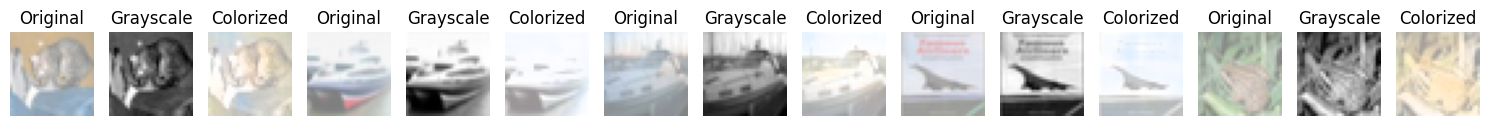

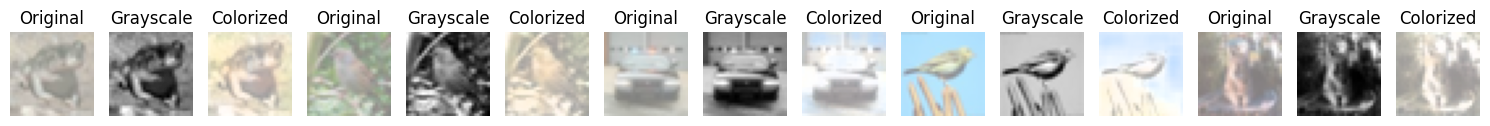

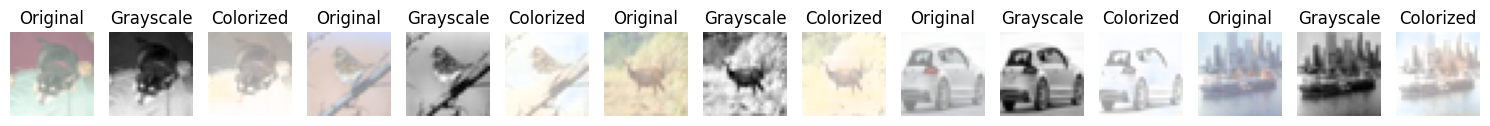

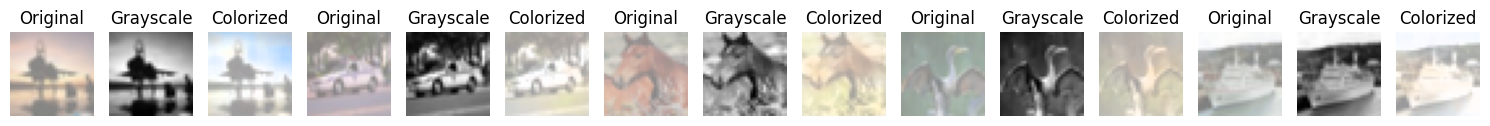

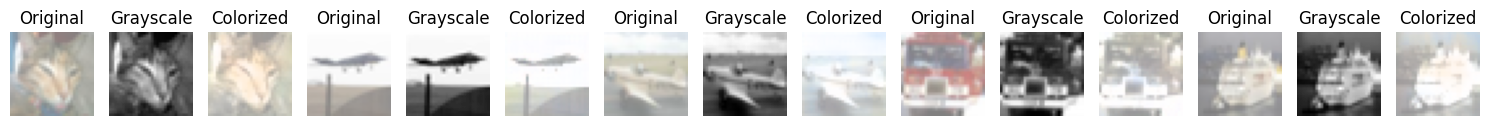

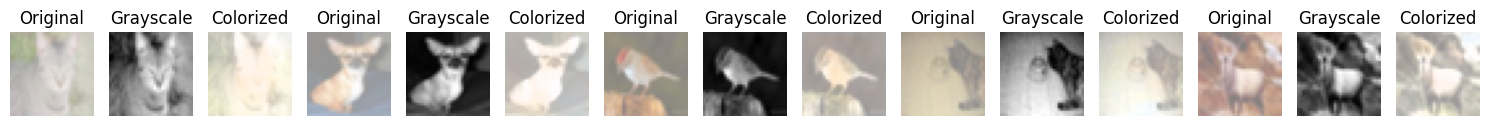

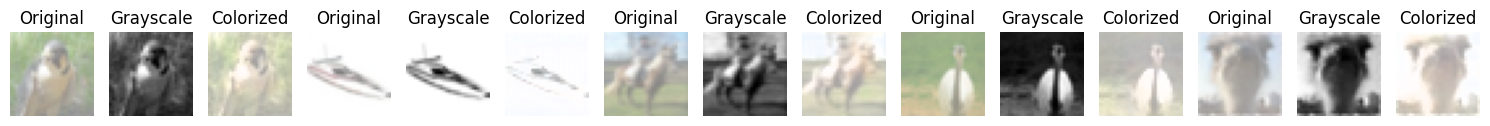

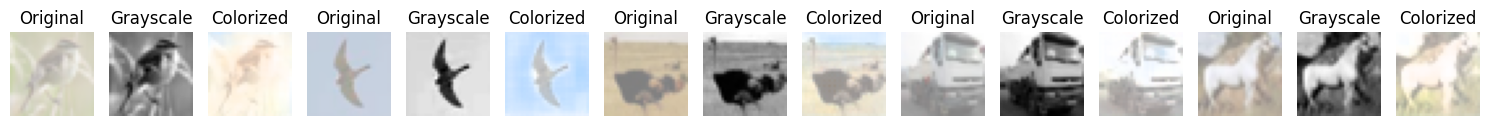

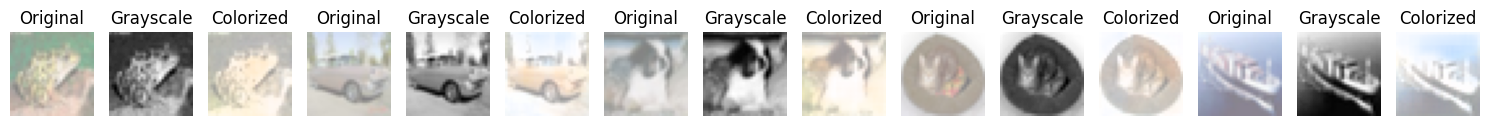

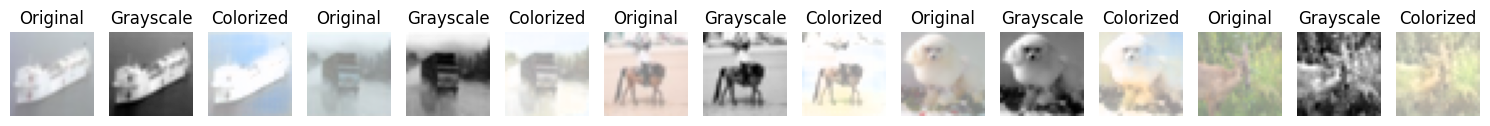

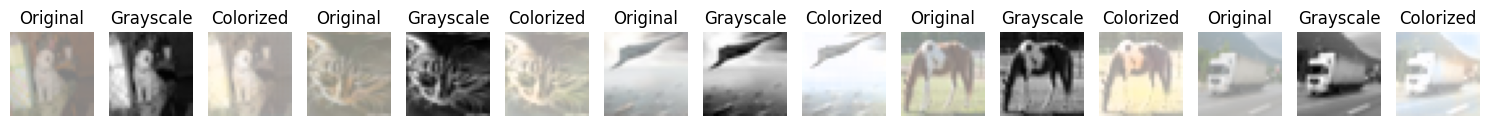

In [9]:
# Save model weights
torch.save(model.state_dict(), "colorization_model_weights.pth")
print("Model weights saved to colorization_model_weights.pth")

with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        colorized_images = model(grayscale_images)


        grayscale_images_cpu = grayscale_images.cpu().squeeze(1)
        colorized_images_cpu = colorized_images.cpu()
        original_images_cpu = images.cpu()

        #colorized_images_cpu=scale_predicted_colors(colorized_images_cpu)
        colorized_images_cpu=exaggerate_colors(colorized_images_cpu)

        # Visualize the grayscale, colorized, and original images
        visualize_all_three(original_images_cpu, grayscale_images_cpu, colorized_images_cpu)

        if i == 10:  # only do this for up to certain batch for demonstration purposes
            break

In [10]:
# --- Colorize your own black and white image ---
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Path to your grayscale image (change this to your file)
img_path = r"C:\Users\thedy\Downloads\360_F_182074922_2RzEqi83dEdCAF19EyVKciPeoUIBEiY7.jpg"  # Example path (note the r prefix)

# Load image as grayscale
img = Image.open(img_path).convert('L')  # 'L' mode = grayscale

# Convert to tensor and normalize to [0,1]
to_tensor = transforms.ToTensor()  # outputs shape (1, H, W)
gray_tensor = to_tensor(img).unsqueeze(0)  # shape (1, 1, H, W)

# Move to device
gray_tensor = gray_tensor.to(device)

# Run through model
with torch.no_grad():
    colorized = model(gray_tensor)
    colorized = colorized.squeeze(0).cpu()  # shape (3, H, W)

# Convert to numpy for display
colorized_np = colorized.permute(1, 2, 0).numpy()

# Show original and colorized
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Input Grayscale')
axs[0].axis('off')
axs[1].imshow(colorized_np)
axs[1].set_title('Colorized Output')
axs[1].axis('off')
plt.show()

# Optionally save the colorized result
out_path = img_path.rsplit('.', 1)[0] + '_colorized.png'
Image.fromarray((colorized_np * 255).astype('uint8')).save(out_path)
print(f'Saved colorized image to: {out_path}')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\thedy\\Downloads\\360_F_182074922_2RzEqi83dEdCAF19EyVKciPeoUIBEiY7.jpg'

Testing on 10 images

In [11]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

# --- Settings ---
base_dir = os.getcwd()  # current notebook folder
input_folder = os.path.join(base_dir, "image_dataset", "test_black")
output_folder = os.path.join(base_dir, "image_dataset", "test_colorized")
os.makedirs(output_folder, exist_ok=True)

num_images = 10  # set None to colorize ALL images

to_tensor = transforms.ToTensor()

# List all .jpg images
all_images = [f for f in os.listdir(input_folder) if f.lower().endswith(".jpg")]

# Select the number of images to process
if num_images is not None:
    all_images = all_images[:num_images]

print(f"Processing {len(all_images)} images...")

for filename in all_images:
    img_path = os.path.join(input_folder, filename)

    # Load grayscale
    img = Image.open(img_path).convert("L")

    # Preprocess
    gray_tensor = to_tensor(img).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        colorized = model(gray_tensor).squeeze(0).cpu()

    # Tensor → image
    colorized_np = colorized.permute(1, 2, 0).numpy()
    colorized_img = Image.fromarray((colorized_np * 255).astype("uint8"))

    # Save result
    save_name = filename.rsplit(".", 1)[0] + "_colorized.png"
    out_path = os.path.join(output_folder, save_name)
    colorized_img.save(out_path)

    print(f"Saved: {out_path}")

print("Batch colorization complete!")


Processing 10 images...
Saved: c:\Users\YiShian\Documents\GitHub\colorization\image_dataset\test_colorized\image4251_colorized.png
Saved: c:\Users\YiShian\Documents\GitHub\colorization\image_dataset\test_colorized\image4252_colorized.png
Saved: c:\Users\YiShian\Documents\GitHub\colorization\image_dataset\test_colorized\image4253_colorized.png
Saved: c:\Users\YiShian\Documents\GitHub\colorization\image_dataset\test_colorized\image4254_colorized.png
Saved: c:\Users\YiShian\Documents\GitHub\colorization\image_dataset\test_colorized\image4255_colorized.png
Saved: c:\Users\YiShian\Documents\GitHub\colorization\image_dataset\test_colorized\image4256_colorized.png
Saved: c:\Users\YiShian\Documents\GitHub\colorization\image_dataset\test_colorized\image4257_colorized.png
Saved: c:\Users\YiShian\Documents\GitHub\colorization\image_dataset\test_colorized\image4258_colorized.png
Saved: c:\Users\YiShian\Documents\GitHub\colorization\image_dataset\test_colorized\image4259_colorized.png
Saved: c:\Use